Research Notes



In [1]:
# These packages are pre-installed on Google Colab, but are included here to facilitate running this notebook locally
!pip install --quiet matplotlib
!pip install --quiet scikit-learn
!pip install --quiet numpy
!pip install --quiet scipy
!pip install --quiet pacmap
!pip install --quiet leidenalg
!pip install --quiet sinfo
# snRNA-seq analysis
!pip install --quiet scanpy
!pip install --quiet omnipath
!pip install --quiet decoupler

In [2]:
!git clone https://github.com/EugOT/CN-pr-MDD-snRNA-seq.git
%cd /content/CN-pr-MDD-snRNA-seq/

fatal: destination path 'CN-pr-MDD-snRNA-seq' already exists and is not an empty directory.
/content/CN-pr-MDD-snRNA-seq


In [3]:
import os
import random
import pacmap
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import decoupler as dc

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from anndata.experimental.multi_files import AnnCollection

# Load Data

In [4]:
samples_males = pd.read_csv("data/PRJNA602867.tsv", delimiter="\t")
samples_males = samples_males[["Run", "Condition", "LibraryName", "BioProject", "Sex", "NTotalCells"]]

samples_females = pd.read_csv("data/PRJNA883411.tsv", delimiter="\t")
samples_females = samples_females[["Run", "Condition", "LibraryName", "BioProject", "Sex", "NTotalCells"]]

In [5]:
samples_females

,Run,Condition,LibraryName,BioProject,Sex,NTotalCells
0,SRR21678773,1,mdd,PRJNA883411,female,1602
1,SRR21678785,0,control,PRJNA883411,female,1365
2,SRR21678788,1,mdd,PRJNA883411,female,2237
3,SRR21678791,1,mdd,PRJNA883411,female,831
4,SRR21678795,0,control,PRJNA883411,female,1109
5,SRR21678807,1,mdd,PRJNA883411,female,2007
6,SRR21678808,1,mdd,PRJNA883411,female,2296
7,SRR21678809,0,control,PRJNA883411,female,2245
8,SRR21678810,1,mdd,PRJNA883411,female,3724
9,SRR21678774,1,mdd,PRJNA883411,female,2276


In [6]:
males = sc.read_h5ad(
    "data/PRJNA602867-whole_dataset-fpr_0.001-clusters.h5ad"
)
males.obs['Run'] = males.obs['orig.ident']
males.obs = pd.merge(samples_males, males.obs, on="Run").set_index("cell_name", drop=False)
males.uns["name"] = "PRJNA602867"
sc.pp.filter_cells(males, min_genes=200)
sc.pp.filter_genes(males, min_cells=5)

females = sc.read_h5ad(
    "data/PRJNA883411-whole_dataset-fpr_0.001-clusters.h5ad"
)
females.obs['Run'] = females.obs['orig.ident']
females.obs = pd.merge(females.obs, samples_females, on="Run", how = "inner").set_index("cell_name", drop=False)
females.uns["name"] = "PRJNA883411"
sc.pp.filter_cells(females, min_genes=200)
sc.pp.filter_genes(females, min_cells=5)

In [7]:
males

AnnData object with n_obs × n_vars = 50507 × 30899
    obs: 'Run', 'Condition', 'LibraryName', 'BioProject', 'Sex', 'NTotalCells', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_RAW', 'nFeature_RAW', 'cell_name', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'doublet_score', 'nFeature_Diff', 'nCount_Diff', 'percent_mito', 'percent_ribo', 'percent_mito_ribo', 'percent_hb', 'log10GenesPerUMI', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1.00000000000001', 'SCT_snn_res.1.09272704265675', 'SCT_snn_res.1.20384663081665', 'SCT_snn_res.1.33943351508602', 'SCT_snn_res.1.50856859076111', 'SCT_snn_res.1.72546094880136', 'SCT_snn_res.2.01366298494275', 'SCT_snn_res.2.41526093678579', 'SCT_snn_res.3.01357061755138', 'SCT_snn_res.4.00000100000009', 'seurat_clusters', 'k_tree', 'n_genes'
    var: 'name', 'n_cells'
    uns: 'name'
    obsm: 'X_pacmap', 'X_pca', 'X_umap'

In [8]:
males.obs = males.obs[[
    'cell_name',
    'background_fraction',
    'droplet_efficiency',
    'doublet_score',
    'nFeature_Diff',
    'nCount_Diff',
    'percent_mito',
    'percent_ribo',
    'percent_mito_ribo',
    'percent_hb',
    'log10GenesPerUMI',
    'k_tree',
    'Run',
    'Condition',
    'BioProject',
    'Sex',
    'n_genes']]

females.obs = females.obs[[
    'cell_name',
    'background_fraction',
    'droplet_efficiency',
    'doublet_score',
    'nFeature_Diff',
    'nCount_Diff',
    'percent_mito',
    'percent_ribo',
    'percent_mito_ribo',
    'percent_hb',
    'log10GenesPerUMI',
    'k_tree',
    'Run',
    'Condition',
    'BioProject',
    'Sex',
    'n_genes']]

In [9]:
sc.experimental.pp.highly_variable_genes(males, flavor="pearson_residuals", n_top_genes=5000)
sc.experimental.pp.highly_variable_genes(females, flavor="pearson_residuals", n_top_genes=5000)

males.obs["k_tree"] = males.obs["Sex"].astype(str) + "_" + males.obs["k_tree"].astype(str)
females.obs["k_tree"] = females.obs["Sex"].astype(str) + "_" + females.obs["k_tree"].astype(str)

In [10]:
#commented because merker genes not combined
"""
adata = ad.concat([males, females], join="inner")
adata.layers["raw"] = adata.X.copy()
adata.layers["sqrt_norm"] = np.sqrt(sc.pp.normalize_total(adata, inplace=False)["X"])
adata.raw = adata
sc.experimental.pp.recipe_pearson_residuals(adata, n_top_genes=2000, batch_key="Run")
"""

'\nadata = ad.concat([males, females], join="inner")\nadata.layers["raw"] = adata.X.copy()\nadata.layers["sqrt_norm"] = np.sqrt(sc.pp.normalize_total(adata, inplace=False)["X"])\nadata.raw = adata\nsc.experimental.pp.recipe_pearson_residuals(adata, n_top_genes=2000, batch_key="Run")\n'

# Check quality of data

In [11]:
#Doublet
#sc.pp.scrublet(females, batch_key="cell_name")

In [12]:
# Saving count data
males.layers["counts"] = males.X.copy()
females.layers["counts"] = females.X.copy()

In [13]:
#Normale with count depth scaling and apply log
sc.pp.normalize_total(males, target_sum=1e4)
sc.pp.log1p(males)

sc.pp.normalize_total(females, target_sum=1e4)
sc.pp.log1p(females)

In [14]:
sc.pp.highly_variable_genes(females, min_mean=0.1, max_mean=5, min_disp=0.5, n_top_genes=2500)
#sc.pl.gighly_variable_genes(females)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


In [15]:
#neighborhood graph
sc.pp.neighbors(females)
sc.tl.umap(females)

In [17]:
females

AnnData object with n_obs × n_vars = 25121 × 30266
    obs: 'cell_name', 'background_fraction', 'droplet_efficiency', 'doublet_score', 'nFeature_Diff', 'nCount_Diff', 'percent_mito', 'percent_ribo', 'percent_mito_ribo', 'percent_hb', 'log10GenesPerUMI', 'k_tree', 'Run', 'Condition', 'BioProject', 'Sex', 'n_genes'
    var: 'name', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable', 'dispersions', 'dispersions_norm'
    uns: 'name', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pacmap', 'X_pca', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [21]:
"""
sc.pl.umap(
    females,
    color="?",
    size=2
)
"""

'\nsc.pl.umap(\n    females,\n    color="?",\n    size=2\n)\n'

In [22]:
sc.tl.leiden(females, flavor="igraph", n_iterations=2)

sc.tl.umap(females)

KeyError: 'Could not find key log1p_total_counts in .var_names or .obs.columns.'

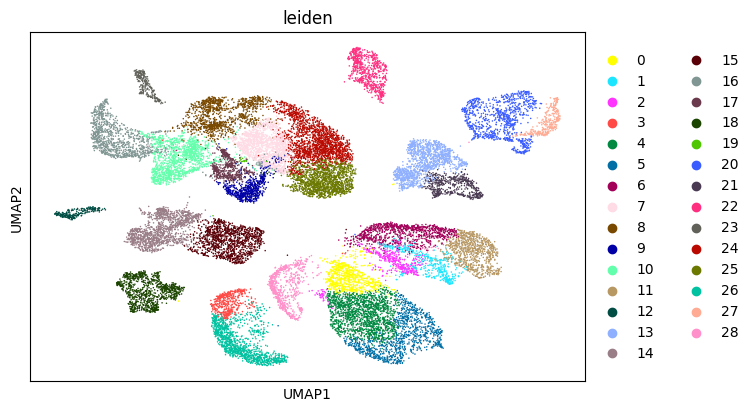

In [23]:
sc.pl.umap(
    females,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

# Marker Genes

In [ ]:
marker_genes_males = pd.read_csv("data/Nagy_2020_mdd_all_mrk-logreg_sct-combined-whole_dataset.csv")
marker_genes_males = marker_genes_males[marker_genes_males.p_val_adj < 0.001]
marker_genes_males["pct.diff"] = marker_genes_males["pct.1"] - marker_genes_males["pct.2"]
marker_genes_males = marker_genes_males[(((marker_genes_males["pct.2"] < 0.02) & (marker_genes_males["pct.diff"] > 0.3)) & (marker_genes_males["avg_log10FC"] > 1.2)) | ((marker_genes_males["pct.diff"] > 0.5) & (marker_genes_males["avg_log10FC"] > 1.5))]
marker_genes_males["cluster"] = marker_genes_males["cluster"].astype(str)


marker_genes_females = pd.read_csv("data/Maitra_2023_mdd_all_mrk-logreg_sct-combined-whole_dataset.csv")
marker_genes_females = marker_genes_females[marker_genes_females.p_val_adj < 0.001]
marker_genes_females["pct.diff"] = marker_genes_females["pct.1"] - marker_genes_females["pct.2"]
marker_genes_females = marker_genes_females[(((marker_genes_females["pct.2"] < 0.02) & (marker_genes_females["pct.diff"] > 0.3)) & (marker_genes_females["avg_log10FC"] > 1.2)) | ((marker_genes_females["pct.diff"] > 0.5) & (marker_genes_females["avg_log10FC"] > 1.5))]
marker_genes_females["cluster"] = marker_genes_females["cluster"].astype(str)
#marker_genes_females = marker_genes_females[marker_genes_females["gene"]=="PVALB"]

In [ ]:
sc.pl.dotplot(females, marker_genes_females, groupby="leiden_res_0.02", standard_scale="var")